# **Machine Learning (ML) Methods**

**Unsupervised Learning**

**KMeans clustering**

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')  

In [8]:
# Load your data
df = pd.read_csv("lightcast_job_postings.csv") 

In [9]:
# Combine fields
df['TITLE_CLEAN'] = df['TITLE_CLEAN'].fillna('unknown').astype(str).str.strip().str.lower()
df['SOFTWARE_SKILLS_NAME'] = df['SOFTWARE_SKILLS_NAME'].fillna('').astype(str).str.lower()
df['ONET_NAME'] = df['ONET_NAME'].fillna('').astype(str).str.lower()
df['SPECIALIZED_SKILLS_NAME'] = df['SPECIALIZED_SKILLS_NAME'].fillna('').astype(str).str.lower()
# Combine text fields for TF-IDF
df['combined_text'] = df['TITLE_CLEAN'] + ' ' + df['SOFTWARE_SKILLS_NAME'] + ' ' + df['ONET_NAME'] + ' ' + df['SPECIALIZED_SKILLS_NAME']

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Vectorize
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['combined_text']).toarray()

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tfidf) 

In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Evaluation
reference_label = 'NAICS2_NAME'  # Try all 3 and compare
df_eval = df[[reference_label, 'cluster']].dropna()

ari = adjusted_rand_score(df_eval[reference_label], df_eval['cluster'])
nmi = normalized_mutual_info_score(df_eval[reference_label], df_eval['cluster'])
# sil_score = silhouette_score(X_scaled, df['cluster'])

print(f"Adjusted Rand Index ({reference_label}): {ari:.3f}")
print(f"Normalized Mutual Info Score ({reference_label}): {nmi:.3f}")
# print(f"Silhouette Score: {sil_score:.3f}") 

Adjusted Rand Index (NAICS2_NAME): 0.030
Normalized Mutual Info Score (NAICS2_NAME): 0.018


In [13]:
# Top terms per cluster
import numpy as np

terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(optimal_k):
    print(f"\n Cluster {i}:")
    print(", ".join([terms[ind] for ind in order_centroids[i, :20]]))


 Cluster 0:
pmi, institute, apple, ios, android, vmware, desktop, methodology, expectation, zachman, windows, infrastructure, capability, operating, subcontracting, library, mobile, application, project, sigma

 Cluster 1:
data, language, programming, sql, python, tableau, analysis, dashboard, bi, power, statistics, visualization, analyst, analytics, software, science, statistical, extract, transform, etl

 Cluster 2:
sap, enterprise, consultant, applications, oracle, functional, planning, management, cloud, architect, solution, architecture, design, erp, resource, technology, chain, supply, requirements, application


In [14]:
import plotly.express as px
import pandas as pd

# Sample 10 titles per cluster
title_samples = df.groupby('cluster')['TITLE_CLEAN'].apply(lambda x: x.dropna().head(10)).reset_index()

# Plotly strip plot (aka dot plot)
fig = px.strip(
    title_samples,
    x='cluster',
    y='TITLE_CLEAN',
    stripmode='overlay',
    orientation='v',
    title="Sample Job Titles by Cluster",
    labels={"TITLE_CLEAN": "Job Title", "cluster": "Cluster"},
    color='cluster'
)

fig.update_traces(jitter=0.3, marker=dict(size=8, opacity=0.7), selector=dict(type='scatter'))
fig.update_layout(height=600, width=900, yaxis_tickfont_size=10)
fig.show()

In [16]:
# Average salary per cluster
avg_salaries = df.groupby('cluster')['SALARY'].mean()

# Print results
for i, avg in avg_salaries.items():
    print(f"Average salary in Cluster {i}: ${avg:,.2f}")


Average salary in Cluster 0: $132,148.75
Average salary in Cluster 1: $105,556.52
Average salary in Cluster 2: $127,697.70


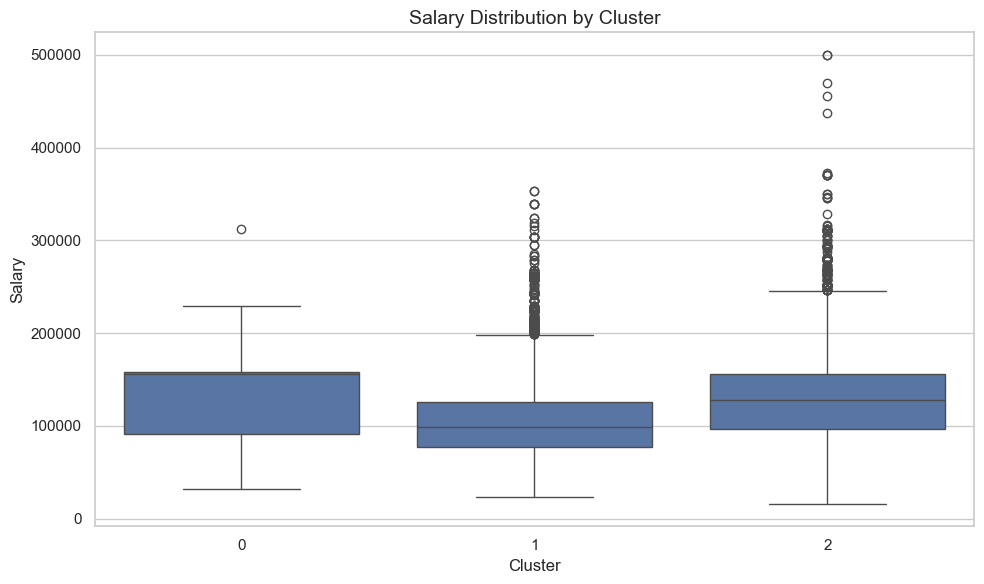

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='SALARY', data=df)

plt.title("Salary Distribution by Cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()

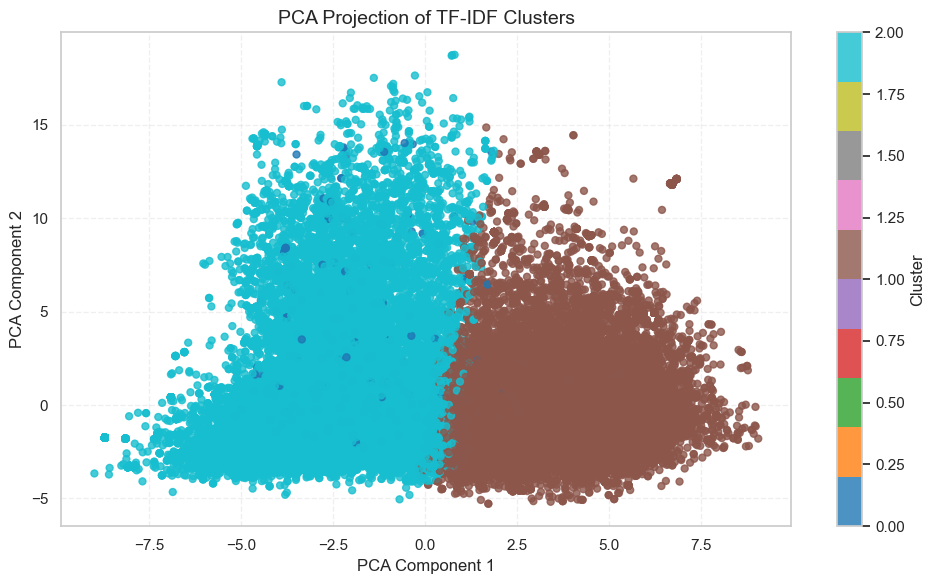

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='tab10', s=25, alpha=0.8)

plt.title("PCA Projection of TF-IDF Clusters", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()